 # MVPA
 based on https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [1]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [2]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_04_musicnoise_bold', 'features')

# brain masks
#mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
# mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c_res-2_dilated.nii')
# mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c_mask_dilate_resample_crop.nii')
# 
n_runs_per_sub = 4

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_features.npy') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_labels.npy') & f.startswith('sub-')]
label_files.sort()

In [4]:
# get number of subjects
n_subjects = len(dataset_files) / n_runs_per_sub
print('Number of subjects found: %d' % n_subjects)

Number of subjects found: 17


In [5]:
# concatenate all datasets in dataset_files
print('Concatenating datasets...')
D = np.concatenate([np.load(f) for f in dataset_files], axis=0)
print('Dataset shape: %s' % str(D.shape))

Concatenating datasets...
Dataset shape: (6528, 16)


In [6]:
# concatenate all labels into a single string array
print('Concatenating labels...')
labels = np.concatenate([np.load(f, allow_pickle=True) for f in label_files], axis=0)
print('Labels shape: %s' % str(labels.shape))

Concatenating labels...
Labels shape: (6528,)


In [7]:
# Load mask
#masker = NiftiMasker(mask_img=mask_brain_file, standardize=False, detrend=False)
#samples = masker.fit_transform(D)
samples = D

In [8]:
# generate an array of chunk labels
# 17 subjects, 8 noise and 9 x 2 music for each of the 4 runs
n_noise_trials = 8
n_noise_splits = 3
n_music_trials = 9*2
n_music_splits = 4
chunks = np.repeat(np.arange(1,n_subjects+1), 
                   n_noise_trials*n_runs_per_sub*n_noise_splits + n_music_trials*n_runs_per_sub*n_music_splits)

In [9]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced')
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()

## Manual Leave One Subject Out Cross Validation

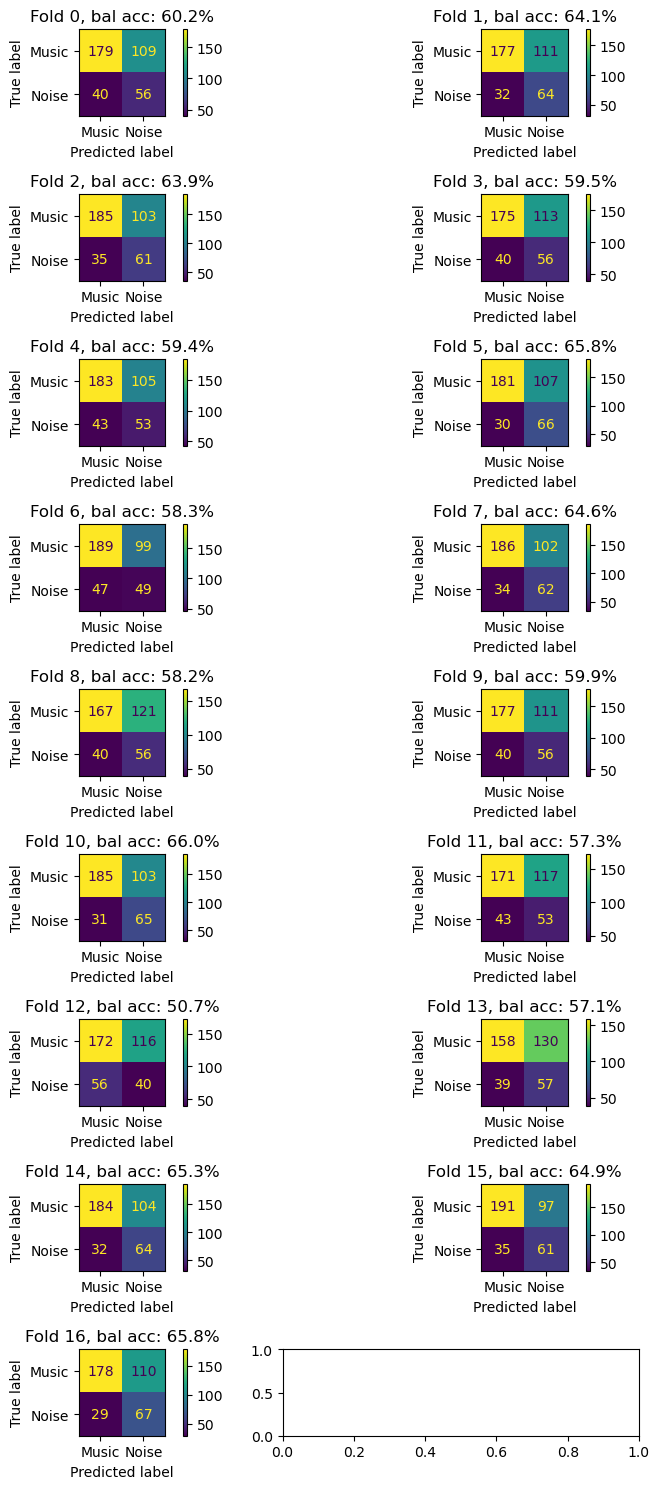

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = int(n_subjects)
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

fig, ax = plt.subplots(9, 2, figsize=(8, 15))

for ff in range(n_folds):
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask, :]
    y_train = labels[train_mask]
    X_test = samples[test_mask, :]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()


In [11]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 61.6% ± 3.1%
Mean balanced accuracy: 61.2% ± 4.1%
